![alt text](https://miro.medium.com/max/1000/1*z7hd8FZeI_eodazwIapvAw.png)

# Lab 4

Welcome to your fourth lab! This notebook contains all the code and comments that you need to submit. Labs are two weeks long and the places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you have run all your cells from top to bottom (you can click _Kernel_ and _Restart Kernel and Run All Cells_). Submit this Jupyter Notebook and also submit the .py file that is generated.__

In [136]:
## This code snippet does not need to be edited
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
from python_environment_check import check_packages
from python_environment_check import set_background

## Colour schemes for setting background colour
white_bgd = 'rgba(0,0,0,0)'
red_bgd = 'rgba(255,0,0,0.2)'

In [137]:
## Code snippets in red (similar to this) is where you need to edit your answer)
# Set your student ID and name here:

student_number = 12345678  # 12345678
student_name = "John Doe" # "John Doe"

set_background(red_bgd)

## What you are going to do in this lab exercise!

In this laboratory exercise, you will create algorithms to train non-linear models like CNNs. 

In all of the tasks below, you should use PyTorch Lightning to design, train and test your CNN models. You can use matplotlib, pandas and numpy to visualize and study your results. 

<div class="alert alert-block alert-warning">
    
- **Section 1** : Design a shallow CNN and use it to classify samples from the Fashion-MNIST dataset. 
- **Section 2** : Design a shallow CNN and use it to classify STL images.
- **Section 3** : Design a deep CNN and use it to classify STL images.
    
It is highly recommended that you write re-usable and efficient code for Section 1, as you will be using similar structures in Sections 2 and 3. A lot of the implementation can be recycled for the future sections, although you also need to think about what needs to change in your code between sections!
    
</div>

## Section 1 : Design a shallow CNN to classify samples from the Fashion-MNIST dataset.


<div class="alert alert-block alert-info">

## What you should in Section 1!!

In Section 1 you will be training a Shallow CNN to classify images using the data file "Section1_data.npz", which is the Fashion-MNIST dataset that contains images and labels for training, validation and test purposes (The images are 28x28 grayscale images).

You will use PyTorch's inbuilt datasets class, and Pytorch Lightning's module class to construct a CNN in order to perform training and testing on the given datasets using stochastic gradient descent (SGD).
    
#### In detail, you will work on the following points:
 1. Create training, validation and testing dataloaders.
 2. Design a shallow neural network model (CNN).
 3. Perform training and model evaluation for different settings. Report test accuracies.
 4. Visualize experimental results for training losses and validation accuracies.
 5. Visualize predictions.
 6. Discussion.

The purpose of this section is to attain/improve your knowledge of CNNs, on the same problem that you have solved in the previous lab. There are differences in what each network architecture does (MLP, CNNs, etc.) so it is good to understand your data before applying these architectures! This is why the dataset will look similar to your lab 3, and you will be noting down the differences between this lab and the previous lab!

You will also notice that many of the steps identical, except for some small differences such as your class defining your network, and the way you pre-process and post-process the data. This is the beauty of PyTorch and more generally, modular differentiable programming.

### Import required libraries and packages

In [138]:
# If you run on Jupyter Lab uncomment bellow comment
#! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics" 

# If you run on google colab uncomment bellow comment
#!pip install "pytorch-lightning" "torchmetrics"  -qq
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mpcol

import torch 
import torch.nn as nn 
from torch.nn import functional as F
from torch import optim
import torchmetrics
import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms

from IPython.core.display import display
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import clear_output

from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint



# For reproducability
seed_everything(1234, workers=True)

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

C:\Users\DELL\AppData\Local\Temp\ipykernel_29872\1527001996.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
Global seed set to 1234


### 1.1 Create and test a shallow CNN

The following class reads in the data for Section 1 and creates a torch dataset object for it. With this, you can easily use a dataloader to train your model. We have provided the code for creating a custom dataloader. You will be editing this to incorporate data augmentation in later tasks.

_Note: Make sure that the file "Section1_data.npz" is located properly and adapt/specify the path if required (in this example, it should be in the same folder as this notebook)._

Define a dataloader class as you have done in lab 3 for the Fashion-MNIST data.

### Note!!! We have rearranged Section1_data to be train -> val -> test in that order. If you are copying and pasting from lab 3, please follow the order that we have specified here!! 

The class Section1Data has been provided for you.

In [139]:
class Section1Data(Dataset):
    def __init__(self, trn_val_tst = 0, transform=None):
        # Load numpy data
        data = np.load('Section1_data.npz')
        if trn_val_tst == 0:
            # Create dataset for trainloader --> images arr_0, labels arr_1
            self.images = data['arr_0'].T
            self.labels = data['arr_1']
        elif trn_val_tst == 1:
            # Create dataset for valloader --> images arr_2, labels arr_3
            self.images = data['arr_2'].T
            self.labels = data['arr_3']
        else:
            # Create dataset for testloader --> images arr_4, labels arr_5
            self.images = data['arr_4'].T
            self.labels = data['arr_5']
            
        self.images = np.asarray(self.images).reshape(-1, 28, 28, 1).astype('float32') /255.0
        self.transform = transform   ## Save the transforms as your class' attributes

    # Define len function
    def __len__(self):
        return len(self.labels)

    # Define getitem function
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        
        if self.transform is not None:  ## If there is a transform, apply it here to your sample
            sample = self.transform(sample)
            
        return sample, labels

Now, your task it to create dataloaders using the dataset class. Ensure that you have created your loaders for your train set, validation set, and test set! Set the shuffle to "True" for your train set, and shuffle to "False" for the validation and test sets. 

In [140]:
set_background(red_bgd)

BATCH_SIZE = 100   
# Call training dataset and create the trainloader. Make sure to transform your data to tensor!!!! Shuffle your training data
trainset = Section1Data(trn_val_tst=0,transform=transforms.ToTensor())  
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)


# Call validation dataset and create the valloader. Make sure to transform your data to tensor!!!!
valset = Section1Data(trn_val_tst=1,transform=transforms.ToTensor()) 
valloader = DataLoader(valset,batch_size=BATCH_SIZE,shuffle=False)

# Call testing dataset and create the testloader. Make sure to transform your data to tensor!!!!
testset = Section1Data(trn_val_tst=2,transform=transforms.ToTensor()) 
testloader = DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False)

Design a Shallow CNN with two convolutional layers. Refer to the PDF for the shallow CNN architecture and its hyperparameters.

_Hint: When creating your layers, make sure to calculate the dimension size of your feature maps/intermediate stages as they will change since we are not using any padding in this case. The dimensions can be calculated with the formula provided in the lectures._

In [141]:
set_background(red_bgd)

class Shallow_CNN(LightningModule):
    def __init__(self, learning_rate=1e-1, train_loader=trainloader, val_loader=valloader, test_loader=testloader):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.loss_fun = nn.CrossEntropyLoss()
        self.train_loader=train_loader
        self.val_loader=val_loader
        self.test_loader=test_loader
        
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512, 32)
        self.out = nn.Linear(32, 10) # The output FC layer
        
        self.train_accuracy = Accuracy() 
        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()
            
    def forward(self, x):
        #Pass input through conv layers
        # conv 1
        x = self.pool(F.relu(self.conv1(x)))

        # conv 2
        x = self.pool(F.relu(self.conv2(x)))

        # fc1
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        # output
        out = self.out(x)
        # don't need softmax here since we'll use cross-entropy as activation.
    
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)

        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)

        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)
        
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(1)
        return [preds, y]

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return self.train_loader
    
    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader

Train and evaluate the model. Ensure that the training loss is decreasing. Plot the train and validation accuracy to ensure that the curves are reasonable. Record your best validation accuracy. You will be trying to improve on this! 

In [146]:
set_background(red_bgd)

# Initialize Shallow CNN model
model_1 = Shallow_CNN()

# Define checkpoint callback function to save best model
checkpoint_callback_1a = ModelCheckpoint(
    monitor="val_acc",
    dirpath="logs_task_1a/",
    save_top_k=1,
    mode="max",
    every_n_epochs=1
)

# Train and test the model
trainer_1a = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=100,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_1a],
    logger=CSVLogger(save_dir="logs_task_1a/"),
    deterministic=True
)
trainer_1a.fit(model_1)
trainer_1a.test()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type             | Params
----------------------------------------------------
0 | loss_fun       | CrossEntropyLoss | 0     
1 | conv1          | Conv2d           | 416   
2 | conv2          | Conv2d           | 12.8 K
3 | pool           | MaxPool2d        | 0     
4 | fc1            | Linear           | 16.4 K
5 | out            | Linear           | 330   
6 | train_accuracy | Accuracy         | 0     
7 | val_accuracy   | Accuracy         | 0     
8 | test_accuracy  | Accuracy         | 0     
----------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Restoring states from the checkpoint path at F:\咸鱼\pytorch-lightning\Lab_4_Students\logs_task_1a\epoch=24-step=15000-v2.ckpt
Loaded model weights from checkpoint at F:\咸鱼\pytorch-lightning\Lab_4_Students\logs_task_1a\epoch=24-step=15000-v2.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9049999713897705
        test_loss           0.2728886008262634
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2728886008262634, 'test_acc': 0.9049999713897705}]

If your implementation is correct, you should obtain a printed output similar to this:

[{'test_loss': 0.6381114721298218, 'test_acc': 0.9011250138282776}] 

### 1.2 Optimize the model's performance using data augmentation

In this task, we provide you with some transformations to improve on your model. Answer the following questions:

In [147]:
set_background(red_bgd)

## What is the purpose of transformations?
## transform提供了一种将数学变换应用于整个数据集的样本和标签的方法。 上述案例中使用到了 ToTensor()，它可以将所有样本和标签转换为张量。能兼容的输入神经网络以进行模型训练。

## Why do we apply random flips to the train data, but not the validation or test data?
## 这称为数据增强。 通过对训练集应用随机仿射变换，我们使用人工数据增加样本量。 这不需要在验证和测试集中发生，因为我们要采用真实数据测试和验证模型。验证模型的鲁棒性。


List of transforms have been composed for you

In [148]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(p=0.05),
                                      transforms.RandomVerticalFlip(p=0.05),
                                      transforms.RandomRotation(degrees=10)])

transform_val_test = transforms.Compose([transforms.ToTensor()])

Recreate dataloaders with transformations (ensure you pass in your transforms as a parameter to your dataloader class)

In [149]:
set_background(red_bgd)

BATCH_SIZE = 100   

# Call training dataset and create the trainloader 
# Make sure to pass the train_transforms through the trainset
trainset_data_aug = Section1Data(trn_val_tst=0, transform=transform_train)  
trainloader_data_aug = DataLoader(trainset_data_aug,batch_size=BATCH_SIZE,shuffle=True)

# Make sure to pass the val_transforms through the valset
# Call validation dataset and create the valloader
valset_data_aug = Section1Data(trn_val_tst=1,transform=transform_val_test) 
valloader_data_aug = DataLoader(valset_data_aug,batch_size=BATCH_SIZE,shuffle=False)

# Make sure to pass the val_transforms through the testset (since it just converts to tensor, we can use the val_transforms)
# Call testing dataset and create the testloader
testset_data_aug = Section1Data(trn_val_tst=2,transform=transform_val_test) 
testloader_data_aug = DataLoader(testset_data_aug,batch_size=BATCH_SIZE,shuffle=False)

### 1.3 Train a shallow CNN based on the augmented data

Train and evaluate the model with data augmentations. You can use the same model you built in Section 1.

In [153]:
set_background(red_bgd)

# Initialize Shallow CNN model
model_2 = Shallow_CNN(train_loader=trainloader_data_aug, val_loader=valloader_data_aug, test_loader=testloader_data_aug)

# Define checkpoint callback function to save best model
checkpoint_callback_1b = ModelCheckpoint(
    monitor="val_acc",
    dirpath="logs_task_1b/",
    save_top_k=1,
    mode="max",
    every_n_epochs=1
)

# Train and test the model
trainer_1b = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=100,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_1b],
    logger=CSVLogger(save_dir="logs_task_1b/"),
    deterministic=True
)
trainer_1b.fit(model_2)
trainer_1b.test()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type             | Params
----------------------------------------------------
0 | loss_fun       | CrossEntropyLoss | 0     
1 | conv1          | Conv2d           | 416   
2 | conv2          | Conv2d           | 12.8 K
3 | pool           | MaxPool2d        | 0     
4 | fc1            | Linear           | 16.4 K
5 | out            | Linear           | 330   
6 | train_accuracy | Accuracy         | 0     
7 | val_accuracy   | Accuracy         | 0     
8 | test_accuracy  | Accuracy         | 0     
----------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Restoring states from the checkpoint path at F:\咸鱼\pytorch-lightning\Lab_4_Students\logs_task_1b\epoch=59-step=36000.ckpt
Loaded model weights from checkpoint at F:\咸鱼\pytorch-lightning\Lab_4_Students\logs_task_1b\epoch=59-step=36000.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9085000157356262
        test_loss           0.2633320987224579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2633320987224579, 'test_acc': 0.9085000157356262}]

If your implementation is correct, you should obtain a printed output similar to this:
    
[{'test_loss': 0.2645968198776245, 'test_acc': 0.9133750200271606}]

### 1.4 Compare validation accuracies obtained with the original data vs. data augmentation

In [154]:
set_background(red_bgd)

# read logs for 1a
training_data_1a = pd.read_csv(trainer_1a.logger.log_dir + "/metrics.csv")
val_acc_1a = training_data_1a["val_acc"].dropna()

# read logs for 1b
training_data_1b = pd.read_csv(trainer_1b.logger.log_dir + "/metrics.csv")
val_acc_1b = training_data_1b["val_acc"].dropna()

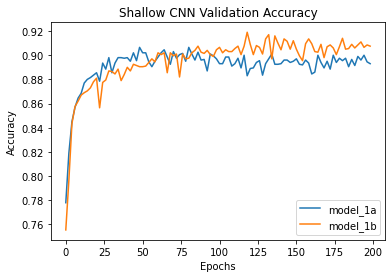

In [155]:
set_background(red_bgd)


# Plot using matplotlib
fig1, ax1 = plt.subplots(1,1)
ax1.plot(val_acc_1a, label="model_1a")
ax1.plot(val_acc_1b, label="model_1b")

ax1.set_title("Shallow CNN Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

plt.legend()
plt.show()

In [32]:
set_background(red_bgd)

## Compare the performances of the two CNNs for the fashion MNIST
## 数据增强明显更好一些

### 1.5 Visualize 5 predictions of the test set along with groundtruths and input images for the best performing CNN model

In this task, we want you to plot out 5 input images of the test set along with their respective predicted and ground-truth labels so that we can compare the predictions with the actual labels. Add in a quick discussion on what the model is able to predict.

E:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 600it [00:00, ?it/s]

E:\Anaconda\lib\site-packages\torch\_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


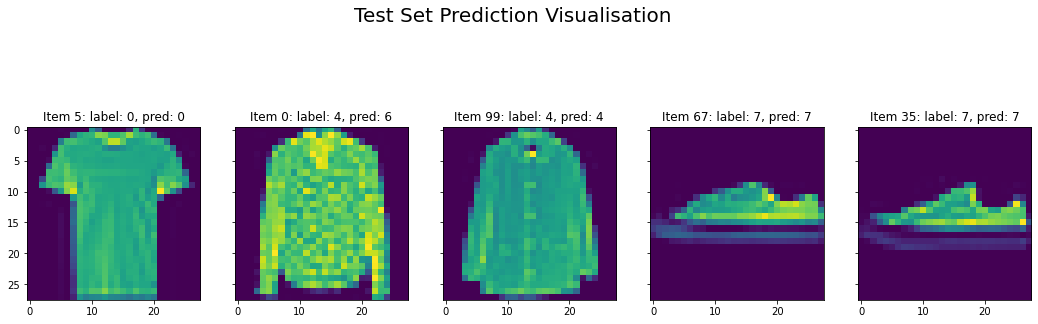

In [33]:
set_background(red_bgd)

# Generate predictions using predict function
outputs = trainer_1b.predict(model_2, testloader_data_aug)

def vis_preds(testloader, predictions):
    test_data, test_labels = next(iter(testloader))
    im_idx = torch.randint(0, test_labels.shape[0], (5,))

    im_label = [predictions[0][0][i] for i in im_idx]
    im_pred = [predictions[0][1][i] for i in im_idx]

    #print(im_idx)
    fig, axs = plt.subplots(1, 5, figsize=(18,6), sharey=True)

    for i, im_num in enumerate(im_idx):
        axs[i].imshow(test_data[im_num].resize(28,28))
        axs[i].set_title(f"Item {im_num}: label: {im_label[i]}, pred: {im_pred[i]}")
    fig.suptitle("Test Set Prediction Visualisation", fontsize=20)
    plt.show()

vis_preds(testloader, outputs)

In [34]:
set_background(red_bgd)

## What do you notice about these best predicted images?
## 预测结果大多是正确的。 不正确的预测结果主要是因为预测样本的衣服与真实标签的衣服看起来很相似。

### 1.6 Describe the differences in using CNNs instead of MLPs

In [35]:
set_background(red_bgd)
##CNN更适合计算机视觉任务，部分原因是在网络中执行卷积操作。这允许网络从周围的图像中学习低级特征，如边缘和阴影的变化。这总体上允许CNN构建更类似于我们感知图像的特征图。
##MLP以不同的方式处理对象分类问题，只是试图从图像中特取高级特征，这些图像在更新颖的样本时表现不佳。

## Section 2 : Design a shallow CNN and use it to classify STL images

<div class="alert alert-block alert-info">

## What you should do in this task!

In this section, we will design a CNN model for another image classification task. During the implementation you will learn how choices in architecture and hyperparameters affect performance. 
    
#### In this task, you will work on the following points:
 1. Create your dataset class using the PyTorch datasets class
    
 2. Create dataloaders for training, validation and testing. Then visualize a sample from the training dataset for each class.
   
 3. Design the Shallow CNN model using the PyTorch Lightning Module. 
    
 4. Train and evaluate the Shallow CNN model on the defined train, validation and test datasets.
    
 5. Visualize your experimental results using Matplotlib.
 
 6. Visualize the 'Top Classified' and 'Top Misclassified Images' from the test set.

### STL Dataset

The dataset we use is <a href="https://cs.stanford.edu/~acoates/stl10/">STL10</a>. Due to size limit on moodle, the data for this lab should be obtained from this
<a href="https://drive.google.com/file/d/1khzPamThzWScipEfMmOPevtfWV7Tx6UL/view?usp=sharing">Link</a> (file is 350MB).
<br>
<br>
The dataset represents 10 object classes, namely __'airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', and 'truck'__ in that order. The dataset has 13,000 color images of size $96 \times 96$. We  divide this into 8,000, 2,000, and 3,000 images for training, validation and testing, respectively. You will use the training images to train your model. You will use the validation set to tune the hyperparameters of your model (e.g., learning rate) or pick a model (e.g., after training for 100 epochs, the model that has the best accuracy on both training and validation images is chosen as the best model). You will use the testing images to report the accuracy of your trained model once you have picked a model according to the above. 


The following class reads the data and creates a torch dataset object for it. With this, you can easily use a dataloader to train your model. Make sure that the file "STL10.npz" is located properly and adapt/specify the path accordingly (in this example, it should be in the data folder).

In [86]:
Image(url= "https://storage.googleapis.com/tfds-data/visualization/fig/stl10-1.0.0.png", width=500, height=500)

### 2.1 Creating a Pytorch dataset for STL10

As usual, create your PyTorch dataset for this section. You will be creating the dataloader with 3 splits: train, validation, and test. The way you can access the data can be seen below:

| Type of data | Access | 
| --- | --- |
| Train data (inputs) | data['arr_0']  |
| Train data (labels)| data['arr_1'] |
| Validation data (inputs) | data['arr_2']  |
| Validation data (labels)| data['arr_3'] |
| Test data (inputs) | data['arr_4']  |
| Test data (labels)| data['arr_5'] |

Order of labels:
{'airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'}


In [87]:
set_background(red_bgd)

# Define a dataset structure for the STL-10 Dataset
class STLData(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None):
        # change with your own path
        data = np.load('STL10.npz')
        if trn_val_tst == 0: 
            #trainloader
            self.images = data['arr_0']
            self.labels = data['arr_1']
        elif trn_val_tst == 1:
            #valloader
            self.images = data['arr_2']
            self.labels = data['arr_3']
        else:
            #testloader
            self.images = data['arr_4']
            self.labels = data['arr_5']
            
        self.images = np.float32(self.images)/1.0
        self.transform = transform ## Define your transforms here

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        if self.transform:  ## If there is a transform, apply it here to your sample
            sample = self.transform(sample)
        return sample, labels

Now that you've defined the STL dataset class, let's create an instance of it for training, validation and testing and then create dataloaders to make it easy to iterate.

__If you have a GPU, and you have installed pytorch-lightning with GPU-enabled, then you can use a large batch_size such as 128.
For the transforms, ensure that you convert the data to a tensor via torchvision.transforms.ToTensor()__

In [92]:
set_background(red_bgd)

n_x_train = 8000   # the number of training datapoints
n_x_val = 2000     # the number of validation datapoints
n_x_test = 3000    # the number of testing datapoints
BATCH_SIZE = 128     # the batch size for training task 1
N_WORKERS = 0 # the batch size for testing task 1

# Data augmentations
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(32),
                                transforms.RandomHorizontalFlip(p=0.3),
                                transforms.RandomVerticalFlip(p=0.3),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

transform_val_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(32),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

# Create an instance of the SineDataset for both the training, validation and test set 
train_set = STLData(trn_val_tst=0,transform=transform )
val_set = STLData(trn_val_tst=1,transform=transform_val_test )
test_set = STLData(trn_val_tst=2,transform=transform_val_test )


# Now we need to pass the dataset to the Pytorch dataloader class along with some other arguments
trainloader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
valloader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
testloader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)


## 2.2 Visualize the dataset

Now visualize the dataset you've created! It is recommended you reshape the first batch (minimum of around 20 samples), which you can access using _next(iter)_.

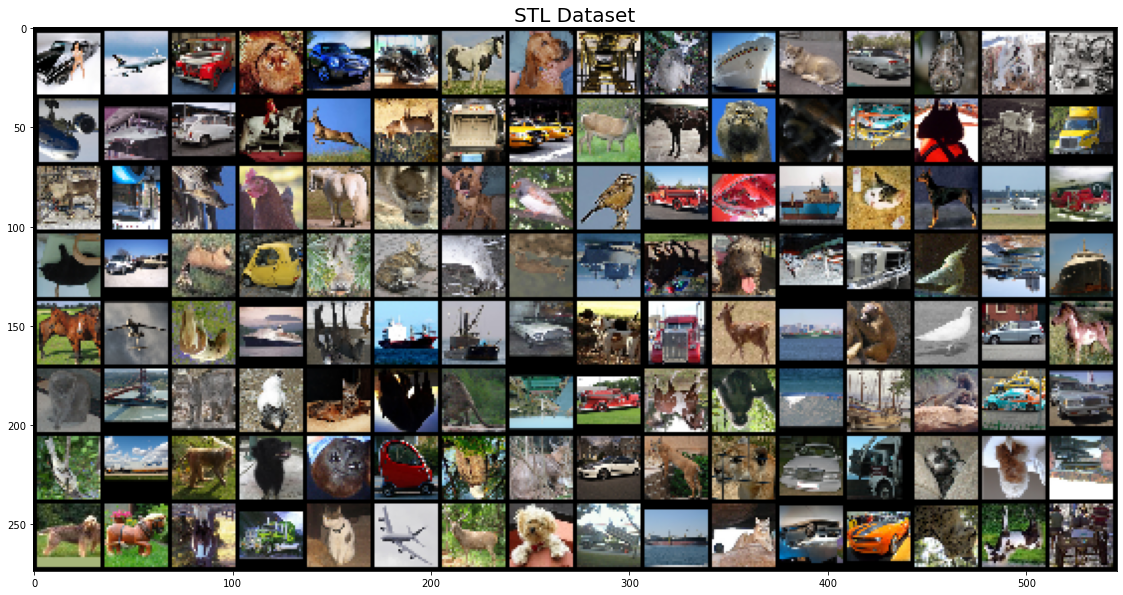

In [94]:
set_background(red_bgd)


# We can create an iterater using the dataloaders and take a random sample 
image, labels = next(iter(trainloader))
#images = images.reshape(-1, 32, 32, 3)

# Reverse normalization on images
inv_normalize = transforms.Normalize(
                    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
                    std=[1/0.5, 1/0.5, 1/0.5]
                )

images = inv_normalize(image)
images = images.reshape(-1, 32, 32, 3)
# visualize dataset using torchvision grid
out = torchvision.utils.make_grid(image, nrow=16, normalize=True)

fig2, ax2 = plt.subplots(1,1)
ax2.imshow(out.numpy().transpose((1, 2, 0)))
ax2.set_title("STL Dataset", fontsize=20)
plt.gcf().set_size_inches(20,10)
plt.show()

### 2.3 Design, train, and test a Shallow CNN

You need to design a shallow CNN and use it to classify STL images. Note that you can reuse a lot of the previous parts to redesign your shallow CNN. The only thing that would change is the input image size, which will be affected by your convolution calculations (as you downsize the image) and hence, affect your fully connected layers as well. Refer to the PDF for the network architecture.

In [98]:
set_background(red_bgd)

class Shallow_CNN(LightningModule):
    def __init__(self, learning_rate=1e-4):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.loss_fun = nn.CrossEntropyLoss()
        
        self.conv1 = nn.Conv2d(3, 32, 7)
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        self.GAP = nn.AdaptiveAvgPool2d(2)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.train_accuracy = Accuracy()
        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()
            
    def forward(self, x):
        #Pass input through conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        #Pass through GAP
        x = self.GAP(x)
        
        #Pass through FC and output it
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)

        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)

        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)
        
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(1)
        return [x, logits, preds, y]

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
                
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader
    
    def val_dataloader(self):
        return valloader

    def test_dataloader(self):
        return testloader

Define training and testing methods for the model. Test the model's performance.

In [99]:
set_background(red_bgd)

# Initialize Model 
model_task2 = Shallow_CNN()

# Train model for 100 epochs
trainer_task2 = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=100,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs_task2/"),
)
trainer_task2.fit(model_task2)

# Evaluate Model
trainer_task2.test()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type              | Params
-----------------------------------------------------
0 | loss_fun       | CrossEntropyLoss  | 0     
1 | conv1          | Conv2d            | 4.7 K 
2 | conv2          | Conv2d            | 51.3 K
3 | GAP            | AdaptiveAvgPool2d | 0     
4 | fc1            | Linear            | 32.9 K
5 | fc2            | Linear            | 1.3 K 
6 | train_accuracy | Accuracy          | 0     
7 | val_accuracy   | Accuracy          | 0     
8 | test_accuracy  | Accuracy          | 0     
-----------------------------------------------------
90.2 K    Trainable params
0         Non-trainable params
90.2 K    Total params
0.361     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Restoring states from the checkpoint path at logs_task2/lightning_logs\version_8\checkpoints\epoch=99-step=6300.ckpt
Loaded model weights from checkpoint at logs_task2/lightning_logs\version_8\checkpoints\epoch=99-step=6300.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6076666712760925
        test_loss           1.0997686386108398
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0997686386108398, 'test_acc': 0.6076666712760925}]

### 2.4 Visualize experimental results

The PyTorch-Lightning module has its own built-in methods to log values. These log files can be then used to visualize experimental results. You can use python plotting libraries such as matplotlib.

Using those logs, plot your train losses.

Note: Make sure to drop NaN entries from dataframes before you plot using matplotlib.

You can read the logs by using the pandas library (pd.read_csv).

In [102]:
set_background(red_bgd)

# read logs for model 
training_data_2 = pd.read_csv(trainer_task2.logger.log_dir + "/metrics.csv")
training_loss_2 = training_data_2["train_loss"].dropna()
val_loss_2 = training_data_2["val_loss"].dropna()

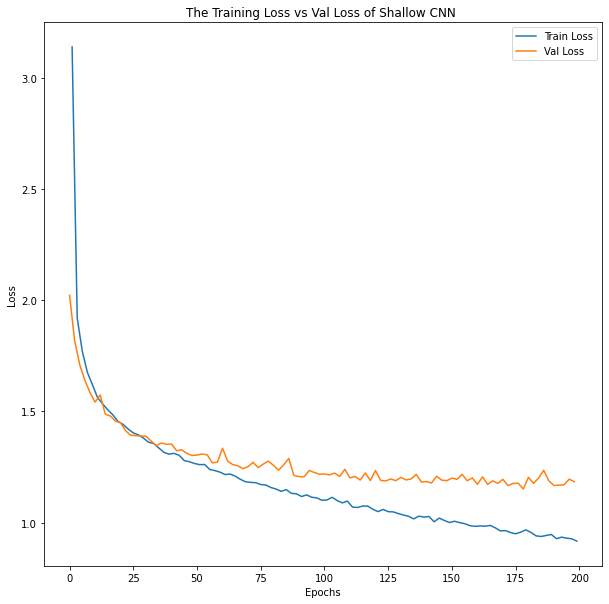

In [103]:
set_background(red_bgd)

## Plot validation and train loss, both against epoch
fig3, ax3 = plt.subplots(1,1)
ax3.plot(training_loss_2, label="Train Loss")
ax3.plot(val_loss_2, label="Val Loss")
ax3.set_title("The Training Loss vs Val Loss of Shallow CNN ")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss")

plt.legend()
plt.gcf().set_size_inches(10,10)
plt.show()

### 2.5 Visualize Top Classified and Top Misclassified Images from the test set

For this section, get the top 5 classified and top 5 misclassified images for each of the classes from the test set and discuss.
In total, you have 10 classes, and (5+5) images for each class, hence you will have 100 images altogether. You can plot the top classified and top misclassified group of images on 2 separate plots / code sections.


The way you could go about this is to:

- Apply a for loop to go through each batch
- Get the predicted probabilities for each image and see if it is correctly classified (or incorrectly classified)
- Rank it based on the predicted probabilities
- Arrange into a neat plot

In [114]:
set_background(red_bgd)

# Define geTopClassified method
# Inside this method you have to call predict_step function, make sure to have softmax probabilities for preditions

def getTopClassified(test_loader, trainer, model, num=5):
    ## test_loader is the dataset
    ## trainer is the train object that updated the model
    ## model is the initialised model
    ## num is the number of images you want to plot per class

    preds = trainer.predict(dataloaders=test_loader) # 24 batches of 128, each entry has form [x, logits, preds, y]
    n_batches = n_x_test/len(preds)

    # save all logit/sm probs
    for i, batch in enumerate(preds):
        incorrect_mask = (batch[2] == batch[3])
        masked_batch = batch[1]*incorrect_mask.unsqueeze(1)
        if i == 0:
            all_sm = F.softmax(masked_batch, dim=-1)
        else:
            all_sm = torch.cat((all_sm, F.softmax(masked_batch, dim=-1)), 0)
        
    # find top {num} logit prob indices (flattened)
    for i in range(10):
        if i == 0:
            top_prob_idx = torch.topk(all_sm[:, i], num).indices
            top_prob_val = torch.topk(all_sm[:, i], num).values
        else:
            top_prob_idx = torch.cat((top_prob_idx, torch.topk(all_sm[:, i], num).indices), -1)
            top_prob_val = torch.cat((top_prob_val, torch.topk(all_sm[:, i], num).values), -1)
    
    top_prob_idx = top_prob_idx.reshape((10,-1))
    top_prob_val = top_prob_val.reshape((10,-1))
    
    # do some math to get correct indexing
    batch_idxs = torch.floor(top_prob_idx/n_batches).type(torch.int)
    img_idxs = torch.remainder(top_prob_idx, n_batches).type(torch.int)

    # get the top {num} un-normalised images into a single tensor
    top_images = []

    for i, cls in enumerate(batch_idxs):
        for j, im in enumerate(cls): #[0, 1, 2, 3, ..., 9]
            top_images.append(inv_normalize(preds[im][0][img_idxs[i][j]]).type(torch.int).permute(1,2,0))

    top_images = torch.stack(top_images).reshape(10,num,32,32,-1)
    
    return top_images, top_prob_val

In [115]:
set_background(red_bgd)


# Define geTopMisclassified method
# Inside this method you have to call predict_step function, make sure to have softmax probabilities for preditions

def getTopMisclassified(test_loader, trainer, model, num=5):
    
    ## test_loader is the dataset
    ## trainer is the train object that updated the model
    ## model is the initialised model
    ## num is the number of images you want to plot per class
    
    preds = trainer.predict(dataloaders=test_loader) # 24 batches of 128, each entry has form [x, logits, preds, y]
    n_batches = n_x_test/len(preds)
    
    # save all logit/sm probs
    for i, batch in enumerate(preds):
        incorrect_mask = (batch[2] != batch[3])
        masked_batch = batch[1]*incorrect_mask.unsqueeze(1)
        if i == 0:
            all_sm = F.softmax(masked_batch, dim=-1)
        else:
            all_sm = torch.cat((all_sm, F.softmax(masked_batch, dim=-1)), 0)
        
    # find top {num} logit prob indices (flattened)
    for i in range(10):
        if i == 0:
            top_prob_idx = torch.topk(all_sm[:, i], num).indices
            top_prob_val = torch.topk(all_sm[:, i], num).values
        else:
            top_prob_idx = torch.cat((top_prob_idx, torch.topk(all_sm[:, i], num).indices), -1)
            top_prob_val = torch.cat((top_prob_val, torch.topk(all_sm[:, i], num).values), -1)
    
    top_prob_idx = top_prob_idx.reshape((10,-1))
    top_prob_val = top_prob_val.reshape((10,-1))
    
    # do some math to get correct indexing
    batch_idxs = torch.floor(top_prob_idx/n_batches).type(torch.int)
    img_idxs = torch.remainder(top_prob_idx, n_batches).type(torch.int)

    # get the top {num} un-normalised images into a single tensor
    top_images = []

    for i, cls in enumerate(batch_idxs):
        for j, im in enumerate(cls): #[0, 1, 2, 3, ..., 9]
            top_images.append(inv_normalize(preds[im][0][img_idxs[i][j]]).type(torch.int).permute(1,2,0))

    top_images = torch.stack(top_images).reshape(10,num,32,32,-1)
    
    return top_images, top_prob_val

In [116]:
set_background(red_bgd)


# Define plotTopClassified method
# Inside this method you have to call getTopClassified mrthod

def plotTopClassified(test_loader, trainer, model, num=5, savename=None):
    max_score_images, max_scores = getTopClassified(test_loader, trainer, model, num)
    rowLabels = ['Airplane', 'Bird', 'Car', 'Cat', 'Deer', 'Dog', 'Horse', 'Monkey', 'Ship', 'Truck']

    fig, axs = plt.subplots(10, num, figsize=(10,20))
    # loop and plot
    for class_num in range(10):
        for i in range(num):
            ## Use np.moveaxis
            ## Use subplot
            ## Turn off xticks and yticks
            ## Plot the images
            axs[class_num, i].imshow(max_score_images[class_num][i])
            axs[class_num, i].set_yticks([])
            axs[class_num, i].set_xticks([], minor=True)

            if i==0:
                axs[class_num, i].set_ylabel(rowLabels[class_num])
            
            axs[class_num, i].set_title(f"Prob: {max_scores[class_num][i].item()*100:.2f}%")
    
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename,dpi=200)

In [117]:
set_background(red_bgd)


# Define plotTopMisclassified method
# Inside this method you have to call getTopMisclassified mrthod

def plotTopMisclassified(test_loader, trainer, model, num=5, savename=None):
    max_score_images, max_scores = getTopMisclassified(test_loader, trainer, model, num)
    rowLabels = ['Airplane', 'Bird', 'Car', 'Cat', 'Deer', 'Dog', 'Horse', 'Monkey', 'Ship', 'Truck']
    
    fig, axs = plt.subplots(10, num, figsize=(10,20))
    for class_num in range(10):
        for i in range(num):
            ## Use np.moveaxis
            ## Use subplot
            ## Turn off xticks and yticks
            ## Plot the images
            axs[class_num, i].imshow(max_score_images[class_num][i])
            axs[class_num, i].set_yticks([])
            axs[class_num, i].set_xticks([], minor=True)

            if i==0:
                axs[class_num, i].set_ylabel(rowLabels[class_num])
            
            axs[class_num, i].set_title(f"Prob: {max_scores[class_num][i].item()*100:.2f}%")
    
    plt.tight_layout()            
    if savename is not None:
        plt.savefig(savename,dpi=200)

Restoring states from the checkpoint path at logs_task2/lightning_logs\version_8\checkpoints\epoch=99-step=6300.ckpt
Loaded model weights from checkpoint at logs_task2/lightning_logs\version_8\checkpoints\epoch=99-step=6300.ckpt


Predicting: 63it [00:00, ?it/s]

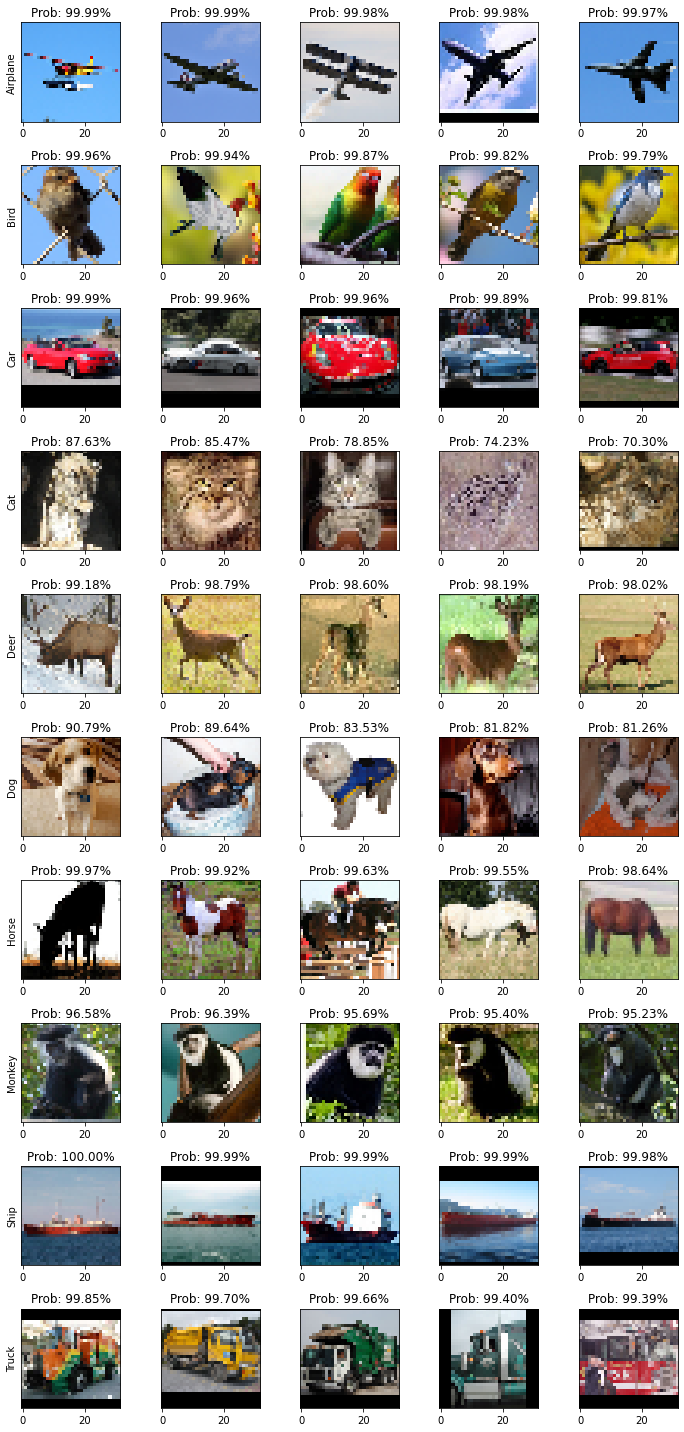

In [118]:
set_background(red_bgd)

# For simplicity of coding, recreate test loader with batch size of 1
testloader_bs1 = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=N_WORKERS, drop_last=False)

# Visualize Top Classified
plotTopClassified(testloader_bs1, trainer_task2, model_task2, num=5, savename='section2_top_classified')

Restoring states from the checkpoint path at logs_task2/lightning_logs\version_8\checkpoints\epoch=99-step=6300.ckpt
Loaded model weights from checkpoint at logs_task2/lightning_logs\version_8\checkpoints\epoch=99-step=6300.ckpt


Predicting: 63it [00:00, ?it/s]

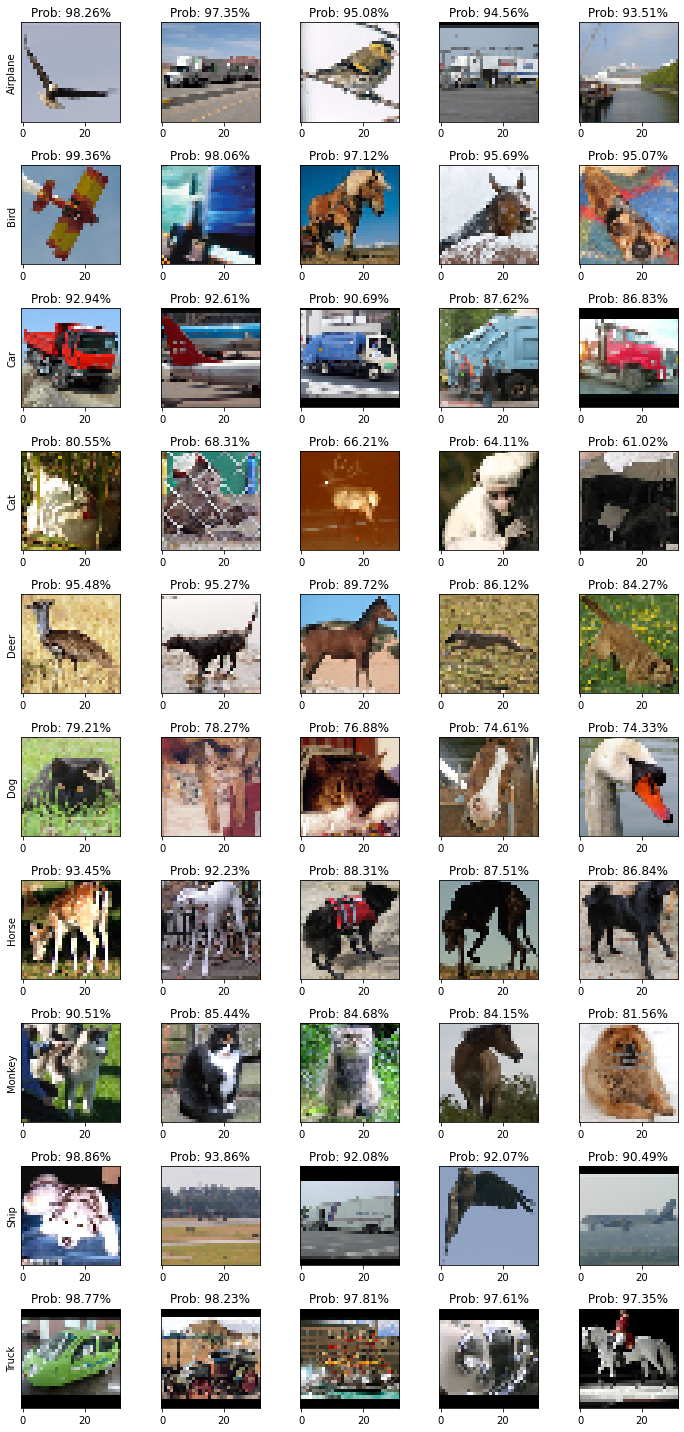

In [119]:
set_background(red_bgd)

# Visualize Top Misclassified

plotTopMisclassified(testloader_bs1, trainer_task2, model_task2, num=5, savename='section2_top_misclassified')

In [120]:
set_background(red_bgd)

# What can you say about the top classified images?
#这些预测有很多相似之处，因此我们可以了解模型从每个类中学到了什么。例如，卡车通常是红色或白色的，具有明显的箱形，狗是白色的，鸟类和飞机具有蓝色背景，而所有预测的猫都有类似的特征。因此，我们可以假设训练数据集是制作的

# What can you say about the top misclassified images?
#它们都很相似。我们可以看到不同的图案，背景，甚至一些东西的姿势。这意味着类似的图像并不经常出现在训练集中，所以很难让模型足够鲁棒。此外，一些图像只是看起来像另一类图像，因此骗过了模型。

## Section 3 : Design and analysis of a deep CNN

<div class="alert alert-block alert-info">

## What you should do in this task!

In this section, we will design a deep CNN model for the above classification task. The purpose of this task is to further improve on the previous model through various techniques, such as hyperparameter tuning and also modifying the model architecture.
    
#### In this task, you will work on the following points:
   
 1. Design the Deep CNN model using the PyTorch Lightning Module. 
    
 2. Train and evaluate the Deep CNN model on the defined train, validation and test datasets.
    
 3. Visualize experimental results using Matplotlib.
 
 4. Visualize the Confusion Matrix for the test set.
 
 5. Discussion.

### 3.1 Design a Deep CNN model

In this section, we will use additional convolutional blocks for the neural network. We will be layering these convolutional blocks so it becomes modular. Modular in this case means that in a convolutional block, the input dimensions (height and width) are the same as the output dimensions (height and width) although the number of channels does not have to be the same. Why is this important? It is so our convolutional blocks can be cascaded without having to worry about changing image sizes! 

In [121]:
set_background(red_bgd)

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out):
        super(ConvBlock, self).__init__()     # Call constructor
        #self.act = ??? ## Activation function
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, padding=1) ## Refer to PDF
        self.conv2 = nn.Conv2d(channels_out, channels_out, 1)
        self.conv3 = nn.Conv2d(channels_out, channels_out, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x
    
    
class Deep_CNN(LightningModule):
    def __init__(self, learning_rate=1e-4):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.loss_fun = nn.CrossEntropyLoss()
        
        self.conv_blk1 = ConvBlock(3, 32)
        self.conv_blk2 = ConvBlock(32, 64)
        self.conv_blk3 = ConvBlock(64, 128)
        self.conv_blk4 = ConvBlock(128, 192)
        self.GAP = nn.AdaptiveAvgPool2d(3)
        
        self.fc1 = nn.Linear(1728, 10)
        
        self.train_accuracy = Accuracy()
        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()
            
    def forward(self, x):
        #Pass input through conv layers
        x = self.conv_blk1(x)
        x = self.conv_blk2(x)
        x = self.conv_blk3(x)
        x = self.conv_blk4(x)
        
        # Pass through GAP
        x = self.GAP(x)
        
        # Pass through FC, and output it
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)

        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)

        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fun(logits, y)
        
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)        

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(1)
        return [x, logits, preds, y]      

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
                
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader
    
    def val_dataloader(self):
        return valloader

    def test_dataloader(self):
        return testloader

### 3.2 Train and visualize results for your deep CNN

Repeat the steps that are similar across all of deep learning:

- Train and test your model
- Visualize experimental results
- Add a discussion

In [123]:
set_background(red_bgd)


# Initialize Model with Adam optimizer
deep_model = Deep_CNN()

# Train model for 150 epochs
trainer_task3 = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=100,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs_task3/")
)
trainer_task3.fit(deep_model)

# Evaluate Model
trainer_task3.test()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type              | Params
-----------------------------------------------------
0 | loss_fun       | CrossEntropyLoss  | 0     
1 | conv_blk1      | ConvBlock         | 11.2 K
2 | conv_blk2      | ConvBlock         | 59.6 K
3 | conv_blk3      | ConvBlock         | 237 K 
4 | conv_blk4      | ConvBlock         | 590 K 
5 | GAP            | AdaptiveAvgPool2d | 0     
6 | fc1            | Linear            | 17.3 K
7 | train_accuracy | Accuracy          | 0     
8 | val_accuracy   | Accuracy          | 0     
9 | test_accuracy  | Accuracy          | 0     
-----------------------------------------------------
916 K     Trainable params
0         Non-trainable params
916 K     Total params
3.666     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Restoring states from the checkpoint path at logs_task3/lightning_logs\version_2\checkpoints\epoch=99-step=6300.ckpt
Loaded model weights from checkpoint at logs_task3/lightning_logs\version_2\checkpoints\epoch=99-step=6300.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6209999918937683
        test_loss            1.073953628540039
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.073953628540039, 'test_acc': 0.6209999918937683}]

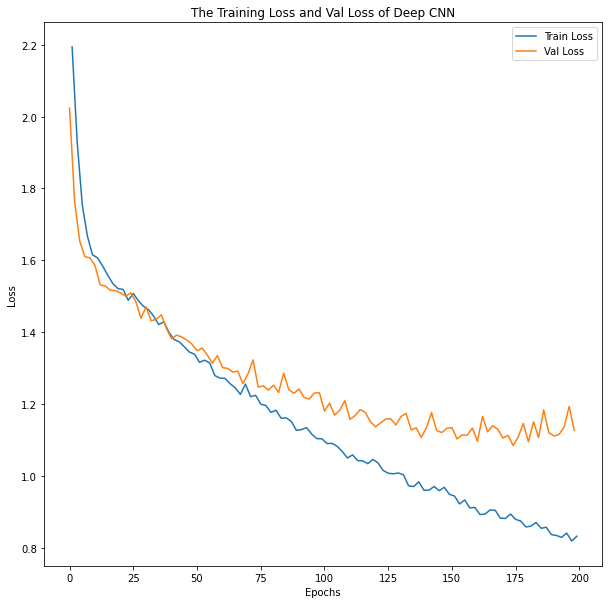

In [124]:
set_background(red_bgd)



# read logs for model trained with Adam
training_data_3 = pd.read_csv(trainer_task3.logger.log_dir + "/metrics.csv")
training_loss_3 = training_data_3["train_loss"].dropna()
val_loss_3 = training_data_3["val_loss"].dropna()

# Visualize results (train and validation loss against epoch)
fig4, ax4 = plt.subplots(1,1)
ax4.plot(training_loss_3, label="Train Loss")
ax4.plot(val_loss_3, label="Val Loss")
ax4.set_title("The Training Loss and Val Loss of Deep CNN")
ax4.set_xlabel("Epochs")
ax4.set_ylabel("Loss")

plt.legend()
plt.gcf().set_size_inches(10,10)
plt.show()


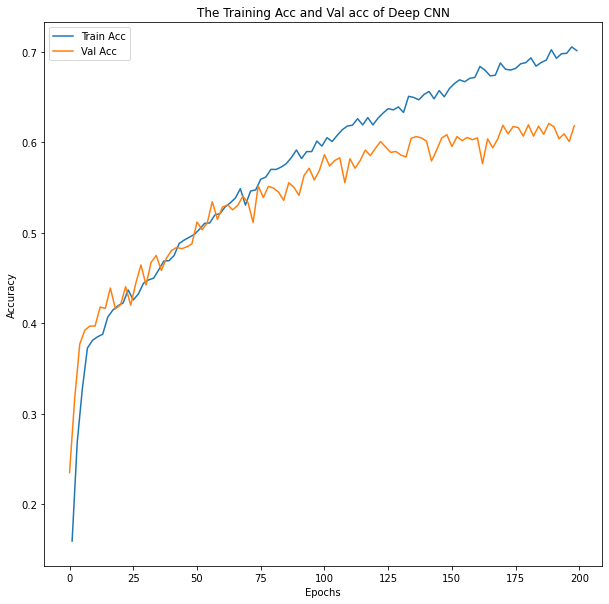

In [125]:
training_acc_3 = training_data_3["train_acc"].dropna()
val_acc_3 = training_data_3["val_acc"].dropna()

fig5, ax5 = plt.subplots(1,1)
ax5.plot(training_acc_3, label="Train Acc")
ax5.plot(val_acc_3, label="Val Acc")
ax5.set_title("The Training Acc and Val acc of Deep CNN")
ax5.set_xlabel("Epochs")
ax5.set_ylabel("Accuracy")

plt.legend()
plt.gcf().set_size_inches(10,10)
plt.show()

Add discussion here!

In [126]:
set_background(red_bgd)


### Question: Is the deeper CNN or the shallow CNN better for this task? 
##深度 CNN 的表现略好于浅层 CNN。

### Question :What implications does stacking CNN layers bring along? Hint: Talk about the features that it builds
##添加额外的卷积层可以使网络构建更强大的特征图。这意味着有更多的低级特征，中级特征和高级特征。随着所学特征范围的扩大，深度CNN能够更好地对图像
##进行分类。例如，低级特征仅从水平/垂直/对角线和边开始。再向下的网络层可能能够识别整个形状，如正方形和圆形（中级特征），然后最后的网络层，
##它将学习更高级别的特征，如猫和狗的头、鸟的翅膀等深层特征。通过更深的CNN，不同级别特征之间有更强大的连接，实现更准确的分类结果。


## Question: Have you seen any strange behaviors during model training? If so what do you recommend to overcome such behaviors?
##在训练期间没有看到任何奇怪的行为。损失似乎在稳步下降，即使在100个epoch，它似乎还没有收敛，
##这意味着精度可以进一步提高。这也通过绘制精度来验证，其中没有任何收敛的迹象。

### Any additional discussion that you would like to include:
##无


### 3.3 Define a Confusion Matrix function and visualize the Confusion Matrix for the test set.

In this task, we will visualize the ability of the network to classify the images in the test set. The confusion matrix is a good way to understand which classes a network is good at classifying, while also seeing the pitfalls of the model (perhaps it confuses a plane with a truck?). Have a look at your result! __You have to build your own confusion matrix, and are NOT allowed to use nor copy an imported library (such as scikit.learn) for this task to build it__ 

What is a confusion matrix? It allows us to tabulate how many instances of each class are:
1) Classified correctly
2) Classified incorrectly and as which class it is classified incorrectly

This allows us to focus on the potential pitfalls/weaknesses of the model, and potentially use this information to improve the model in several ways. Example image of a confusion matrix:

<!-- ![image info]() -->

In [127]:
Image(url= "https://miro.medium.com/max/1400/1*TOVAm14q2GsAnx8q79nQlQ.png", width=500, height=500)

Additional information on confusion matrices: https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/

In [132]:
set_background(red_bgd)

def getConfusionMatrix(test_loader, trainer, model):
    # Number of classes is 10
    # Calculates the 10 x 10 grid for the predictions for each class
    # Rows are actual classes, columns are predicted classes
    confMat = torch.zeros((10,10)).type(torch.int32)   
    
    # get preds
    preds = trainer.predict(dataloaders=test_loader)

    for idx in range(len(test_loader)):
        for j in range(10):
            confMat[j] += preds[idx][3][preds[idx][2]==j].bincount(minlength=10)

    return confMat
       

def plotAllConfMats(model, test_loader, trainer, savename):

    confMat = getConfusionMatrix(test_loader, trainer, model)
    
    # plt.figure(figsize=(9, 5))
    # plt.axis('off') 
    
    cellColours = plt.cm.get_cmap('Greens')((mpcol.Normalize()(np.power(confMat,1/3)))*0.8)
    rowLabels = ['Airplane', 'Bird', 'Car', 'Cat', 'Deer', 'Dog', 'Horse', 'Monkey', 'Ship', 'Truck']

    ax = plt.subplot()
    ax.xaxis.set_ticks([*range(10)])
    ax.xaxis.set_ticklabels(rowLabels)
    ax.set_xlabel('Predicted labels')
    ax.yaxis.set_ticks([*range(10)])
    ax.yaxis.set_ticklabels(rowLabels)
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    plt.gcf().set_size_inches(20,10)
    plt.imshow(cellColours)

    if savename is not None:
        plt.savefig(savename,dpi=200)

Restoring states from the checkpoint path at logs_task3/lightning_logs\version_2\checkpoints\epoch=99-step=6300.ckpt
Loaded model weights from checkpoint at logs_task3/lightning_logs\version_2\checkpoints\epoch=99-step=6300.ckpt


Predicting: 63it [00:00, ?it/s]

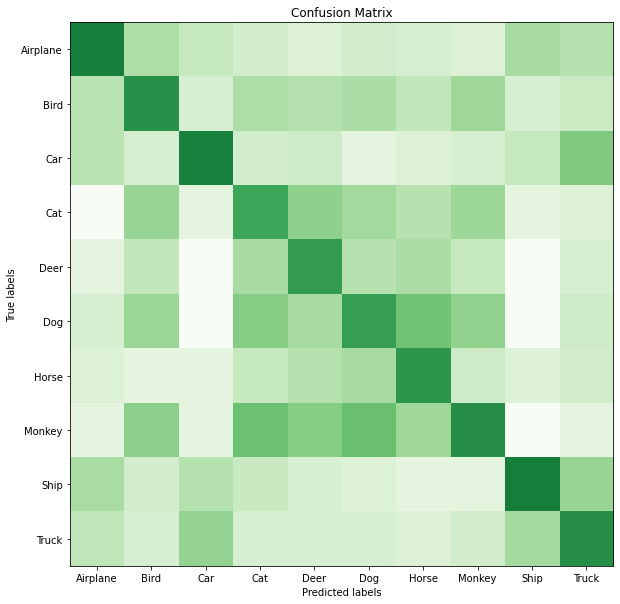

In [133]:
set_background(red_bgd)

plotAllConfMats(deep_model, testloader_bs1, trainer_task3, 'section_3_confMat')

In [134]:
set_background(red_bgd)

## What can you say about this model's ability to predict certain classes? Link it back to the confusion matrix that you have tabulated.
## 模型大部分都预测了正确的类 ，我们可以通过混淆矩阵对角线较暗的方块来看到这一点。
## 正方形越暗，预测的频率就越高。我们还可以看到，一些类经常被错误分类。例如，猴和船的阴影比我们预期的要深，以及汽车和卡车。不出所料，狗和猫也经常被错误分类。

# Do not remove or edit the following code snippet. 

When submitting your report, please ensure that you have run the entire notebook from top to bottom. You can do this by clicking "Kernel" and "Restart Kernel and Run All Cells". Make sure the last cell (below) has also been run. 

In [135]:
file_name = str(student_number) + '_Lab_4_Student'
cmd = "jupyter nbconvert --to script Lab_4_Student.ipynb --output " + file_name
if(os.system(cmd)):
    print("Error converting to .py")
    print(f"cmd: {cmd}")